## Попередня обробка даних

### Вступ

Попередня обробка даних - це важливий етап в аналізі даних. Необхідно заздалегідь підготувати дані таким чином, щоб найкраще розкрити структуру проблеми алгоритмам машинного навчання, які будуть до цих даних застосовуватись. Це передбачає ряд заходів, таких як:
* Присвоєння числових значень категоричним даним;
* Обробка відсутніх значень;
* Нормалізація функцій (щоб функції на малих масштабах не домінували при підключенні моделі до даних).



У розділі 2 "Дослідницький аналіз даних" виконане дослідження, щоб допомогти зрозуміти розподіл даних, а також те, як атрибути співвідносяться між собою. Були визначені функції інтересу. У цьому розділі використовуються функції для оптимізації даних великих розмірів.

### Мета:
Знайти найбільш прогнозовані функції даних і відфільтрувати їх так, щоб це підвищило прогнозовану силу аналітичної моделі.

#### Завантаження даних та основних бібліотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#Завантаження бібліотек для обробки даних
import pandas as pd #обробка даних, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from scipy.stats import norm

# візуалізація
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")


plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.titlesize'] = 'large'

data = pd.read_csv('data/clean-data.csv', index_col=False)
data.drop('Unnamed: 0',axis=1, inplace=True)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Кодування міток
Занесення 30 ознак до NumPy масиву X та перетворення класових міток з їх оригінального рядкового (string) представлення (M та B) в цілочисельне (integer).

In [2]:
#Призначення предикторів до змінної типу ndarray (матриця)
array = data.values
X = array[:,1:31]
y = array[:,0]

In [5]:
#перетворення класових міток з їх оригінального рядкового (string) представлення (M та B) в цілочисельне (integer)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

#метод перетворення LabelEncorder двох фіктивних змінних
le.transform (['M', 'B'])

array([1, 0], dtype=int64)

Після кодування міток класу (діагнозу) у масиві злоякісні пухлини тепер представлені як клас 1 (тобто наявність ракових клітин), а доброякісні пухлини представлені як клас 0 (тобто відсутність ракових клітин) відповідно.


#### Оцінка точності моделі: розбиття даних на навчальні та тестові набори

Найпростіший метод оцінювання продуктивності алгоритму машинного навчання - використання різних наборів даних для навчання та тестування. Кроки:
* Розділити наявні дані на навчальний і тестовий набір. (70% навчання, 30% тесту)
* Навчання алгоритму на першій частині даних
* Зробити прогноз щодо другої частини
* Оцінити прогнози щодо очікуваних результатів

Розмір розбиття може залежати від розміру та специфіки набору даних, хоча зазвичай 67% даних використовується для тренувань, а решта 33% - для тестування.

In [6]:
from sklearn.model_selection import train_test_split

##Розбиття набору даних: 70% для навчання, 30% для тестування
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=7)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((426, 30), (426,), (143, 30), (143,))

#### Стандартизація ознак

* Стандартизація - це корисна методика перетворення атрибутів з гауссовим розподілом та різними відхиленнями у стандартний розподіл Гаусса із середнім значенням 0 та стандартним відхиленням 1.

* Як вже відомо з розділу 2 "Дослідницький аналіз даних" вихідні дані мають різні розподіли, що може впливати на більшість алгоритмів машинного навчання. Алгоритми машинного навчання та оптимізації поводяться набагато краще, якщо функції знаходяться в одному масштабі.

Оцінимо ті самі алгоритми зі стандартизованою копією набору даних. Використовується sklearn для масштабування та перетворення даних таким чином, що кожен атрибут має середнє значення 0 та стандартне відхилення 1.

In [10]:
from sklearn.preprocessing import StandardScaler

# нормалізація даних (центр близький до 0 і масштаб для видалення дисперсії).
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

#### Декомпозиція ознак використовуючи аналіз основних компонентів - Principal Component Analysis (PCA)
В розділі 2 "Дослідницький аналіз даних" були наведені пари ознак, які добре розділяють дані. Тому є сенс використовувати один із методів зменшення розмірності, щоб спробувати використовувати якомога більше функцій та підтримувати якомога більше інформації при роботі з лише двома вимірами. Далі використовується PCA.

In [11]:
from sklearn.decomposition import PCA
# вилучення ознак
pca = PCA(n_components=10)
fit = pca.fit(Xs)

# підсумкові дані
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978]
[[ 2.18902444e-01  1.03724578e-01  2.27537293e-01  2.20994985e-01
   1.42589694e-01  2.39285354e-01  2.58400481e-01  2.60853758e-01
   1.38166959e-01  6.43633464e-02  2.05978776e-01  1.74280281e-02
   2.11325916e-01  2.02869635e-01  1.45314521e-02  1.70393451e-01
   1.53589790e-01  1.83417397e-01  4.24984216e-02  1.02568322e-01
   2.27996634e-01  1.04469325e-01  2.36639681e-01  2.24870533e-01
   1.27952561e-01  2.10095880e-01  2.28767533e-01  2.50885971e-01
   1.22904556e-01  1.31783943e-01]
 [-2.33857132e-01 -5.97060883e-02 -2.15181361e-01 -2.31076711e-01
   1.86113023e-01  1.51891610e-01  6.01653628e-02 -3.47675005e-02
   1.90348770e-01  3.66575471e-01 -1.05552152e-01  8.99796818e-02
  -8.94572342e-02 -1.52292628e-01  2.04430453e-01  2.32715896e-01
   1.97207283e-01  1.30321560e-01  1.83848000e-01  2.80092027e-01
  -2.19866379e-01 -4.54672983e-02 -1.99

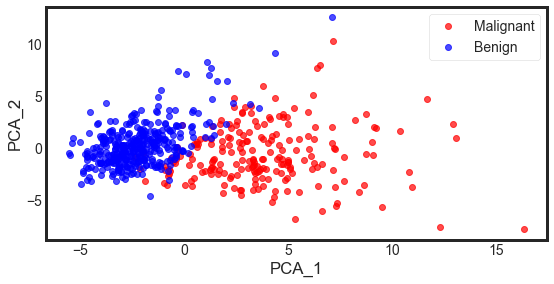

In [12]:
X_pca = pca.transform(Xs)

PCA_df = pd.DataFrame()

PCA_df['PCA_1'] = X_pca[:,0]
PCA_df['PCA_2'] = X_pca[:,1]

plt.plot(PCA_df['PCA_1'][data.diagnosis == 'M'],PCA_df['PCA_2'][data.diagnosis == 'M'],'o', alpha = 0.7, color = 'r')
plt.plot(PCA_df['PCA_1'][data.diagnosis == 'B'],PCA_df['PCA_2'][data.diagnosis == 'B'],'o', alpha = 0.7, color = 'b')

plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.legend(['Malignant','Benign'])
plt.show()

Після застосування лінійної трансформації PCA отримано підпростір (від 3D до 2D), де зразки "найбільш розповсюджені" уздовж нових осей функції.

In [13]:
#кількість дисперсій, яку пояснює кожен головний компонент
var= pca.explained_variance_ratio_
#сукупна варіативність
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)

[44.27 63.24 72.63 79.23 84.73 88.75 91.   92.59 93.98 95.15]


### Вирішення, скільки основних компонентів потрібно зберегти
Для того, щоб визначити, скільки основних компонентів слід зберегти, прийнято узагальнити результати аналізу основних компонентів, склавши графік огляду.

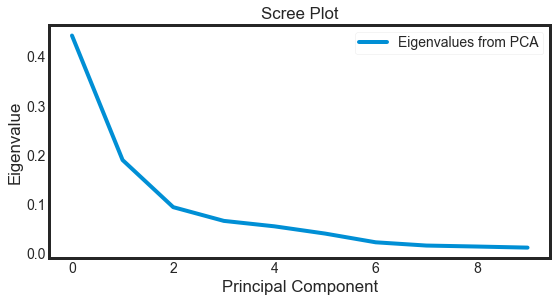

In [15]:
#кількість дисперсій, яку пояснює кожен головний компонент
var= pca.explained_variance_ratio_
#сукупна варіативність
#var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#print(var1)

plt.plot(var)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3,shadow=False,markerscale=0.4)
leg.get_frame().set_alpha(0.4)
plt.show()

Найбільш очевидна зміна нахилу відбувається в компоненті 2, який є «ліктем» графіку власних значень. Таким чином, виходячи з графіку, можна стверджувати, що перші три компоненти слід зберегти.

### Підсумок:

1. Занесення 30 ознак до NumPy масиву X та перетворення класових міток з їх оригінального рядкового представлення (M та B) в цілочисельне.
2. Розбиття даних на навчальні та тестові набори.
3. Стандартизація даних.
4. Отримання власних векторів та значень з матриці коваріації чи матриці кореляції.
5. Сортування власних значень у порядку зменшення та вибір власних векторів kk, які відповідають найбільшим власним значенням kk, де k - розмірність нового підпростору ознак (k≤dk≤d).
6. Побудова проекційної матриці W з вибраних власних векторів k.
7. Перетворення вихідного набору даних X через W, щоб отримати k-мірний підпростір ознак Y.